# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [4]:
# Imports here
# Used for loading the data from a directory structure
# [Pretrained models](https://pytorch.org/docs/master/torchvision/models.html)
from torchvision import transforms, datasets, models

# Used to create dataloader object
import torch
# Otherwise we cannot simply use nn.* ==> torch.nn.*
from torch import nn

# Making sure that all plots are done in line
%matplotlib inline

# To make our own classifier, gives us cleaner code
from collections import OrderedDict

# To create optimizer object
from torch import optim

# To check the performance
import time

# To check progress of iteration
from tqdm import tqdm

# To make translation from label to flower type
import json

# To make an unique copy of our model, not just a variable that points to the same object
import copy

# To change the learning rate with the number of epochs
from torch.optim import lr_scheduler

# To process a single image and make a prediction on this single image
from PIL import Image

import numpy as np

# to plot some nice figures
import matplotlib.pyplot as plt

import seaborn as sns

# Make sure the model and data is always send to the correct device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [5]:
data_dir = 'flowers'

# Define our keys to be used in the dictionaries, might be usefull in case when I have different 
# naming convention for my directories in a different project. In this way I only need to change
# the code at one place:)
# Name used for the training data
trainkey = 'train'
# Name used for validation data
validkey = 'valid'
# Name used for testing data
testkey  = 'test'

train_dir = data_dir + '/' + trainkey
valid_dir = data_dir + '/' + validkey
test_dir  = data_dir + '/' + testkey

# Create dictionary for the different directories that we have
dirs = { trainkey : train_dir
       , validkey : valid_dir
       , testkey  : test_dir}

In [6]:
# Create a dictionary to store all transformations
data_transforms = {
    trainkey: transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    # Note that we do not want randomresizedcrop here, we just want our resized and centercropped image
    validkey: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    # Note that we do not want randomresizedcrop here, we just want our resized and centercropped image
    testkey : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

# now creating our datasets is just a one-liner, this is done with ImageFolder, again just a one-liner (yeah I know it's spread in two lines, but still:))
img_datasets  = {x: datasets.ImageFolder(dirs[x], transform=data_transforms[x]) 
                 for x in [trainkey, validkey, testkey]}

# Is usefull in the do_training function
dataset_sizes = {x: len(img_datasets[x]) 
                 for x in [trainkey, validkey, testkey]}

# Create our dataloader object, again just a one-liner (yeah I know it's spread in two lines, but still:))
dataloaders   = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size=16, shuffle=True) 
                 for x in [trainkey, validkey, testkey]}

# Store the number of features that we are trying to predict in a variable.
clf_output = len(img_datasets[trainkey].classes)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [4]:
# TODO: Build and train your network
# First download the pretrained model
model = models.vgg19(pretrained=True)

# Making sure that the pretrained model weights are not updated by our training
for param in model.parameters():
    param.requires_grad = False

# Store the number of input variables for the classifier in a variable
clf_input = model.classifier[0].in_features

clf_hidden = int(((clf_input - clf_output) / 6) + clf_output)

# Now create our custom classifier with just one hidden layer
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(clf_input, clf_hidden)),
                          ('relu1', nn.ReLU()),
                          ('dp1',nn.Dropout(0.5)),
                          ('fc2', nn.Linear(clf_hidden, clf_output)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
# Replace the existing classifier, and use the custom classifier
model.classifier = classifier

# Store the optimzizer, criterion and scheduler in the model
model.criterion = nn.NLLLoss()
model.optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
model.scheduler = lr_scheduler.StepLR(model.optimizer, step_size=4, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:05<00:00, 100878196.53it/s]


In [7]:
def do_training(model, dataloaders, device, epochs = 4) :
    ###########################################################################################################
    # Function do_training
    # Input parameters
    #    - model       : neural network that will be trained
    #    - dataloaders : dataloader object that is dictionary with dataloader objects in it
    #    - device      : where to execute the code on, options are [cpu|cuda] in the udacity classroom
    #    - epochs      : number of iteration over the complete dataset
    # 
    # Returns
    #    - model       : trained neural network model
    #
    # This function is used to train neural networks. Passing in the dataloader for a validation set allows us
    # to determine per iteration which model is performing the best. Per epoch, iteration over the dataset, 
    # this validation is conducted. Only if the model is performing better than the previous 
    #
    # The code was inspired by https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad
    ###########################################################################################################
    
    # At First I tried to do the training on my local machine, however a single iteration with 64 images in it
    # took more than 8 minutes.. On local machine I have an Intel processor. Googled a lot but was not able to figure out
    # a solution to use the intel processor in a similar way as cuda is being used in the classroom. So then I just stuck 
    # to the workspace provided by Udacity. I would like to know if there is an alternative for an intel processor to 
    # use the GPU in python. Could not find any better option than pyopencl, which would require to write some code
    # ourselves. Does not seem like the correct option to me.
    # My local machine has a GPU: Intel(R) HD Graphics 5500.
    
    model.to(device)
    
    # Store the state_dict of the model in a variable, in case something goes wrong with the logic in this function
    best_model_sd = copy.deepcopy(model.state_dict())
    
    start = time.time()
    
    best_acc = 0
    
    for e in range(epochs) :
        
        # Printinig the epoch number 
        print('Epoch {}/{}'.format(e + 1, epochs))
        print('-' * 11)
        
        # Per iteration we are doing some training and afterwards validation if we improved the model by training it so.
        for phase in [trainkey, validkey] :
            if phase == trainkey :
                # model needs to be put in training mode
                model.train()
                model.scheduler.step()
            else :
                # Then we are validating and don't want to train our model and use dropout etc
                model.eval()
            
            # Reset running values per iteration, initialize it as float so we don't run into problems later on
            running_loss     = 0.0
            running_corrects = 0.0
            
            # Very nice suggestion from a peer to use tqdm to keep track of the progress
            for inputs, labels in tqdm(dataloaders[phase]) :
                # make sure the input and labels is in the correct device
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Make sure that the gradient is reset to zero before we do any learning
                model.optimizer.zero_grad()
                
                # For validation we don't want the gradient, but for testing we do
                # So for testing we set it to true, and for validation we set it to false
                with torch.set_grad_enabled(phase == trainkey) :
                    outputs = model.forward(inputs)
                    loss    = model.criterion(outputs, labels)
                
                # For training we want to the update our model
                if phase == trainkey :
                    loss.backward()
                    model.optimizer.step()
                    
                # Calculate running loss for the phase, keep in account that the number of inputs is variable per phase
                running_loss += loss.item() * inputs.size(0)
                # Calculate predictions
                predictions = torch.max(outputs.data, 1)[1]
                # Calculate total number of correct predictions
                running_corrects += torch.sum(predictions == labels.data)
            
            # For this given phase we are done performing the iteration part. Now print some
            # details about our process
            epoch_loss = running_loss / dataset_sizes[phase]
            # Don't understand why in the bottom one we need to call double() on it, while on running_loss this is not necessary
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # If we do better on the validation set, we want to update the best accuracy variable and copy the state_dict
            # of the model into a new variable
            if phase == validkey and epoch_acc >= best_acc :
                best_acc = epoch_acc
                best_model_sd = copy.deepcopy(model.state_dict())
    print("Total duration was {:.0f}m {:.0f}s.\n Best accuracy was {}".format((time.time() - start) / 60, (time.time() - start) % 60, best_acc))
    
    model.load_state_dict(best_model_sd)
    return model

In [8]:
model = do_training(model, dataloaders, device)

  0%|          | 0/410 [00:00<?, ?it/s]

Epoch 1/4
-----------


  0%|          | 0/52 [00:00<?, ?it/s]

train Loss: 1.2560 Acc: 0.6752


  0%|          | 0/410 [00:00<?, ?it/s]

valid Loss: 0.5133 Acc: 0.8570
Epoch 2/4
-----------


  0%|          | 0/52 [00:00<?, ?it/s]

train Loss: 1.3053 Acc: 0.6615


  0%|          | 0/410 [00:00<?, ?it/s]

valid Loss: 0.5133 Acc: 0.8570
Epoch 3/4
-----------


  0%|          | 0/52 [00:00<?, ?it/s]

train Loss: 1.2449 Acc: 0.6740


  0%|          | 0/410 [00:00<?, ?it/s]

valid Loss: 0.5132 Acc: 0.8570
Epoch 4/4
-----------


  0%|          | 0/52 [00:00<?, ?it/s]

train Loss: 1.2841 Acc: 0.6647


100%|██████████| 52/52 [00:25<00:00,  2.07it/s]

valid Loss: 0.5132 Acc: 0.8570
Total duration was 17m 41s.
 Best accuracy was 0.8569682151589242


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
# TODO: Do validation on the test set
def do_evaluate(model, dataloader, device) :
    ###########################################################################################################
    # Function do_evaluate
    # Input parameters
    #    - model       : neural network that will be trained
    #    - dataloader  : dataloader object that contains only data for a specific set we want to do the evaluation on
    #    - device      : where to execute the code on, options are [cpu|cuda] in the udacity classroom
    # 
    # Returns
    #    - accuracy    : Number of correctly identified elements divided by total number of elements
    #
    # This function is used to evaluate the neural network and check the accuracy.
    ###########################################################################################################
    
    # Use the agnostic code of one of the lessons to make sure it doesn't matter if we execute code on cpu/gpu
    model.to(device)
    # Must set the model in eval mode!!
    model.eval()
    
    correct = 0
    total = 0
    # For these computations we don't need the gradient. torch.no_grad() sets it only for these calculations to no gradient!
    with torch.no_grad():
        # Keep track of the status in the testloader
        for images, labels in tqdm(dataloader):
            # Use the agnostic code of one of the lessons to make sure it doesn't matter if we execute code on cpu/gpu
            images, labels = images.to(device), labels.to(device)
            outputs = model.forward(images)
            # Only interested in the accuracy here, in [0] are the probabilities and in [1] the indexes of the predictions  
            predicted = torch.max(outputs.data, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (100 * correct / total)

In [10]:
print(do_evaluate(model, dataloaders[testkey], device))

100%|██████████| 52/52 [00:24<00:00,  2.62it/s]

82.17338217338218


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [11]:
def save_checkpoint(model, architecture, image_dataset, filename):
    ###########################################################################################################
    # Function save_checkpoint
    # Input parameters
    #    - model          : Neural network model
    #    - architecture   : Name of the pretrained model
    #    - image_dataset  : Dataloader object that contains only data for a specific set we want to do the evaluation on
    #    - filename       : Relative/absolute filepath of checkpoint. Eg 'classifier.pth'
    # 
    # Function to store the current status of the classifier in a checkpoint, so that it can be reloaded in
    # another session. Note that we don't store the complete model. Just the classifier state_dict. This can be
    # done because we don't change the base model, just the classifier. This function only works under the assumption
    # that the classifier contains 3 layers ==> [input|hidden|layer]
    ###########################################################################################################
    model.class_to_idx = image_dataset.class_to_idx
    
    # Dictionary object that contains the number of [input|hidden|output] layers of the classifier
    dim_clf = {'input'  : model.classifier[0].in_features,
               'hidden' : model.classifier[0].out_features,
               'output' : model.classifier[3].out_features}
    
    model.cpu()
    torch.save({'architecture'     : architecture,
                'state_dict'       : model.classifier.state_dict(), 
                'class_to_idx'     : model.class_to_idx,
                'optim_state_dict' : model.optimizer.state_dict(),
                'sched_state_dict' : model.scheduler.state_dict(),
                'dim_clf'          : dim_clf}, 
                filename)

In [12]:
save_checkpoint(model, 'vgg19', img_datasets[trainkey], 'img_classifier.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [8]:
def load_checkpoint(filepath, device):
    ###########################################################################################################
    # Function load_checkpoint
    # Input parameters
    #    - filepath       : Relative or absolute filepath of checkpoint
    #    - device         : where to execute the code on, options are [cpu|cuda] in the udacity classroom
    #
    # Returns
    #    - model          : Neural network object
    # 
    # Function to load the last status of the classifier from a checkpoint
    ###########################################################################################################
    
    #Load the checkpoint
    checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)
    
    # Note that we did not store the complete model in the previous exercise, so that one we need to import as well
    if   checkpoint['architecture'] == 'vgg16' :
        model = models.vgg16(pretrained=True)
    elif checkpoint['architecture'] == 'vgg19' :
        model = models.vgg19(pretrained=True)
    else :
        print("The architecture {} is not recognized, returned None instead".format(architecture))
        return None
    
    # Making sure that we freeze the pretrained model weights, otherwise things will go south very soon.
    for param in model.parameters():
        param.requires_grad = False
    
    dim_clf = checkpoint['dim_clf']
    # Now we want to rebuild the classifier, but first we need to initialize it
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(dim_clf['input'], dim_clf['hidden'])),
                          ('relu1', nn.ReLU()),
                          ('dp1',nn.Dropout(0.5)),
                          ('fc2', nn.Linear(dim_clf['hidden'], dim_clf['output'])),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
    
    model.classifier = classifier
    model.classifier.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    # We did not store this but making sure that we have the criterion in the model object.
    model.criterion = nn.NLLLoss()
    
    # Initially I thought I would have to put this statements just before returning the model, however this results in 
    # errors for the optimizer that is stored in the model. So first put the model on cuda, and then add the optimizer
    # and scheduler.
    model.to(device)
    
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    model.optimizer = optimizer
    model.optimizer.load_state_dict(checkpoint['optim_state_dict'])
    
    scheduler = lr_scheduler.StepLR(model.optimizer, step_size=4, gamma=0.1)
    model.scheduler = scheduler
    model.scheduler.load_state_dict(checkpoint['sched_state_dict'])
    
    return model

In [9]:
model = load_checkpoint('img_classifier.pth', device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:05<00:00, 96050222.20it/s] 


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [10]:
def process_image(image_path):
    ###########################################################################################################
    # Function process_image
    # Input parameters
    #    - image_path     : Relative/absolute filepath of image. 
    #                       Eg '/home/workspace/aipnd-project/flowers/test/28/image_05230.jpg'
    # Returns
    #    - numpy array    : converted image to a numpy array
    # 
    # Scales, crops, and normalizes a PIL image for a PyTorch model,
    # returns an Numpy array
    ###########################################################################################################
    
    # First create a PIL object to do some transformations.
    pil_img = Image.open(image_path)
    
    # Resize the longest side (width/height) to 256, preservering the ratio
    img = transforms.Resize(256)(pil_img)
    
    # Now we need to do some cropping, we need the following logic to keep an image of 224 by 224 pixels
    lmargin = (img.width-224) / 2   # left
    bmargin = (img.height-224) / 2  # bottom
    rmargin = lmargin + 224         # right
    tmargin = bmargin + 224         # top
    
    img = img.crop((lmargin, bmargin, rmargin, tmargin)) 
    
    # Now it is time to convert our pil image to a numpy array.
    img = np.array(img) / 255

    # Do some normalization on the image
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225]) 
    img  = (img - mean) / std

    # Make sure that color is the first dimension, this is what our model is expecting
    img = img.transpose((2, 0, 1))

    return img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [12]:
def imshow(image, ax=None, title=None):
    ###########################################################################################################
    # Function imshow
    # Input parameters
    #    - image          : A processed image that is being returned from function process_image
    #    - ax             : Axes of matplotlib
    #    - title          : Title of the flower that is being displayed
    # 
    # Displays an image that was cropped and resized by process_image
    ###########################################################################################################
    if ax is None:
        fig, ax = plt.subplots()
    
    # Add a title to the plot if this is given in the function call
    if title:
        plt.title(title)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes it is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing and normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

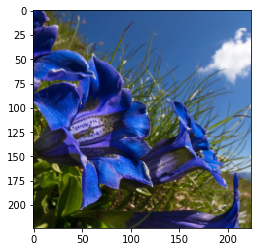

In [13]:
imshow(process_image(r'/home/workspace/aipnd-project/flowers/test/28/Stemless-Gentian-Gentiana-acaulis-0555.jpg'))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [14]:
def predict(image_path, model, topk=5):
    ###########################################################################################################
    # Function predict
    # Input parameters
    #    - image_path     : Relative/absolute filepath of image. 
    #                       Eg '/home/workspace/aipnd-project/flowers/test/28/image_05230.jpg'
    #    - model          : Neural network model
    #    - topk           : the top k largest probabilities that the model predicts, by default this value is 
    #                       set to 5.
    # Returns
    #    - topk_prob      : the topk highest values of probabilites
    #    - topk_flower    : the corresponding flower names
    # 
    # Predict the class (or classes) of a single image using a trained deep learning model. Note that I chose
    # to return only the probabilities and the flower name. Not the corresponding value that corresponds to a 
    # flower. This is in my opinion what this function should do.
    ###########################################################################################################

    # The model needs to be in evualate mode, we don't want to train it on accident and use dropout xD
    model.eval()
    
    # Process image using the function that I have created
    img = process_image(image_path) 
    
    # Now we need to convert our numpy array back to a Tensor. Note that the type of tensor may vary
    # on if we want to execute the code on cpu or on cuda
    img = torch.from_numpy(img).type(torch.FloatTensor) 
    
    # The model expects the batchsize as the first element, it was suggested by josh to use unsqueeze_
    img = img.unsqueeze_(0)

    # Now can use the image as input in our model, we need to convert the outcome of the model to the 
    #probabilities using torch.exp. Since we are doing predictions we don't need the gradients.
    with torch.no_grad() :
        probabilities = torch.exp(model.forward(img))
    
    # With topk function of tensors we get back the highest values and the index of these highest values
    topk_prob, topk_idx = probabilities.topk(topk)
    
    # Convert tensor to list
    topk_prob = topk_prob.tolist()[0]
    topk_idx  = topk_idx.tolist()[0]

    # Convert keys and values in the dictionary that we already have. Now for each index we now to which class value it belong
    # Note that this is a dictionary therefore surrounded by {}
    idx_to_class = {y:x for x,y in model.class_to_idx.items()}
    
    # From the model we got the index back, based on this index we want the retrieve the corresponding value
    # Now we have the value we can make the translation to flower name based on our json file, we already have this
    # json file in memory in the variable cat_to_name
    topk_flower = [cat_to_name[idx_to_class[cls]] for cls in topk_idx]

    return topk_prob, topk_flower

In [15]:
# For this test case I downloaded two custom flowers from google 
# The first one is predicted correct
print(predict(r'/home/workspace/aipnd-project/flowers/test/28/Stemless-Gentian-Gentiana-acaulis-0555.jpg', model))
# The second one is incorrect, the correct flower is not within the top 5
print(predict(r'/home/workspace/aipnd-project/flowers/test/33/love-in-a-mist-persian-jewels-rose-red-flowers.jpg', model))

([0.9960529208183289, 0.003315569134429097, 0.00028280189144425094, 0.00019079408957622945, 6.108733214205131e-05], ['stemless gentian', 'monkshood', 'passion flower', 'columbine', 'love in the mist'])
([0.8989827632904053, 0.03767139092087746, 0.033972665667533875, 0.007236110977828503, 0.006451895926147699], ['sweet william', 'blanket flower', 'bee balm', 'common dandelion', 'carnation'])


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [39]:
def show_prediction(image_path, model):
    ###########################################################################################################
    # Function show_prediction
    # Input parameters
    #    - image_path     : Relative/absolute filepath of image. 
    #                       Eg '/home/workspace/aipnd-project/flowers/test/28/image_05230.jpg'
    #    - model          : Neural network model
    #
    # Returns
    #    - pyplot object with two subplots. One plot containing the image of the flower and the other subplot
    #      containing a bargraph with probabilities of the topk flowers
    # 
    # Visualize the prediction of the model with an image of the flower including the name of the flower along
    # with it. Make a barplot of the topk most likely flowers and their probabilities
    ###########################################################################################################
    # Set up plot, we create two plots, above eachother
    plt.figure(figsize = (6,8))
    ax = plt.subplot(2,1,1)

    # Now do some trick to get the label for the corresponding flower
    # WARNING: this assumes that the first integer that is a directory name in our image_path is the label!!
    title = None
    for i in image_path.split('/') :
        if i.isdigit() :
            # We found the first digit, now store the flower name in the title variable. Since we assume that it is always the 
            # first directory name we can break our for loop
            title = cat_to_name[i]
            break
            
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title)
    # Make our predictions using the model
    probs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);

    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

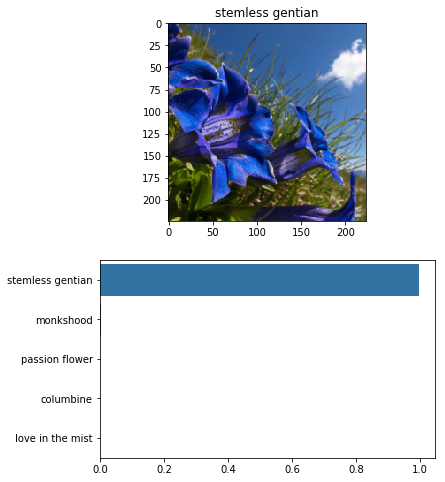

In [40]:
# Uploaded a picture that I found on google of a stemless gentian and evaluated the model. See results below.
show_prediction(r'/home/workspace/aipnd-project/flowers/test/28/Stemless-Gentian-Gentiana-acaulis-0555.jpg', model)